<a href="https://colab.research.google.com/github/evelisko/GB_DL_ComputerVision/blob/main/Lesson_2/HW_DL_Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Свёрточные нейронные сети (СНС)

## Задание
Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10 <br>
Библиотеки: [Python, Tensorflow]

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [126]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

In [127]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [128]:
train_x = train_x.astype(np.float32) / 255.0
test_x = test_x.astype(np.float32) / 255.0

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


## Визуализация датасета CIFAR-10

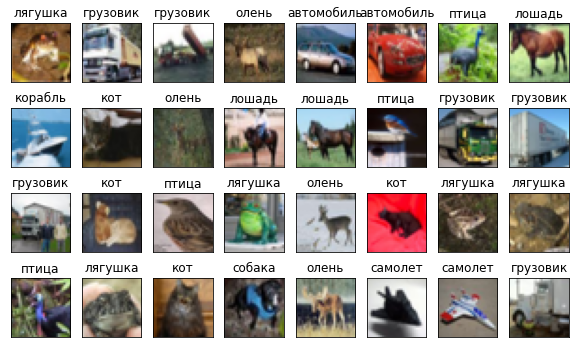

In [132]:
some_samples = train_x[:32, ...]
some_labels = train_y[:32]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,...])
    ax.title.set_text(classes[some_labels[j]])
    plt.xticks([]), plt.yticks([])
plt.show()

In [133]:
# Выполним визуализацию данных. Посмотрим что из этого получится. Как выполнять визуализацию?
# range

## Создание пайплайна данных

In [220]:
NUM_EPOCHS = 5
BATCH_SIZE = 32

num_classes = len(classes)

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [221]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()
        self.batch_norm_5 = tf.keras.layers.BatchNormalization()
        self.batch_norm_6 = tf.keras.layers.BatchNormalization()

        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(num_classes, activation=None) # Прикольно, что здесь не используется softmax.
           
    def call(self, inp): # Динамический граф.
        out = self.conv1(inp)
        out = self.batch_norm_1(out)
        out = self.conv2(out)
        out = self.batch_norm_2(out)
        out = self.max_pool(out)

        out = self.conv3(out)
        out = self.batch_norm_3(out)
        out = self.conv4(out)
        out = self.batch_norm_4(out)
        out = self.max_pool(out)

        # out = self.conv5(out)
        # out = self.batch_norm_5(out)
        # out = self.conv6(out)
        # out = self.batch_norm_6(out)
        # out = self.max_pool(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

## Функция потерь и функция вычисления точности

In [222]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32) # Превращение из категории в число производится здесь.
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

## Подготовка к обучению

In [223]:
LEARNING_RATE = 0.0001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [224]:
loss_list = []
accuracy_list = []

## Цикл обучения модели

In [225]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images) # Модель будет возврящать не массив чисел а тензор из логитов. 
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 500 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%5d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))

        loss_list.append(loss_value)
        accuracy_list.append(accuracy_value)
        
        # with writer.as_default():
        #     tf.summary.scalar('accuracy', accuracy_value, iteration)
        #     tf.summary.scalar('loss', loss_value, iteration)

[    0] Accuracy: 11.33 %
[  500] Accuracy: 33.98 %
[ 1000] Accuracy: 48.44 %
[ 1500] Accuracy: 50.00 %
[ 2000] Accuracy: 54.69 %
[ 2500] Accuracy: 55.47 %
[ 3000] Accuracy: 60.16 %
[ 3500] Accuracy: 66.80 %
[ 4000] Accuracy: 65.62 %
[ 4500] Accuracy: 74.22 %
[ 5000] Accuracy: 70.31 %
[ 5500] Accuracy: 66.41 %
[ 6000] Accuracy: 68.75 %
[ 6500] Accuracy: 69.14 %
[ 7000] Accuracy: 71.09 %
[ 7500] Accuracy: 70.31 %
[ 8000] Accuracy: 70.31 %
[ 8500] Accuracy: 70.70 %
[ 9000] Accuracy: 72.27 %
[ 9500] Accuracy: 70.70 %
[10000] Accuracy: 76.17 %
[10500] Accuracy: 73.05 %
[11000] Accuracy: 75.39 %
[11500] Accuracy: 77.73 %
[12000] Accuracy: 71.48 %
[12500] Accuracy: 73.83 %
[13000] Accuracy: 72.66 %
[13500] Accuracy: 78.12 %
[14000] Accuracy: 75.00 %
[14500] Accuracy: 75.00 %
[15000] Accuracy: 78.12 %
[15500] Accuracy: 76.17 %
CPU times: user 7min 38s, sys: 3.83 s, total: 7min 42s
Wall time: 7min 38s


## Оценка качества модели

In [226]:
%%time
test_logits = model(test_x)

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 102 ms


In [227]:
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 75.43 %


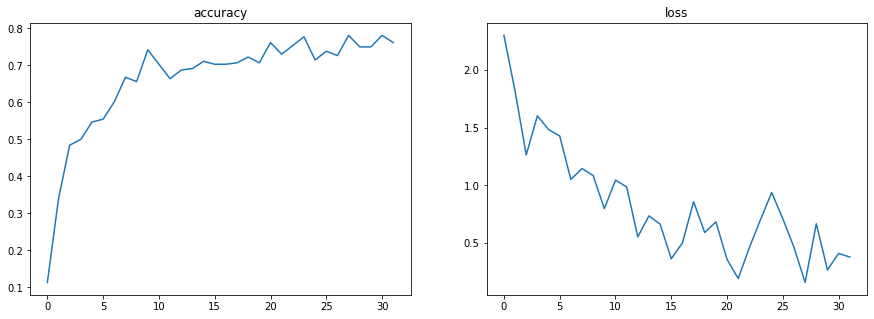

In [228]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15, 5))
ax[0].plot(accuracy_list)
ax[0].title.set_text('accuracy')
ax[1].plot(loss_list)
ax[1].title.set_text('loss')
plt.show()

## Функция для инференса и отображения результата предсказания

In [229]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample)
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {} ({})'.format(classes[ans],ans))

## Запуск предсказания для изображения случайной цифры из MNIST

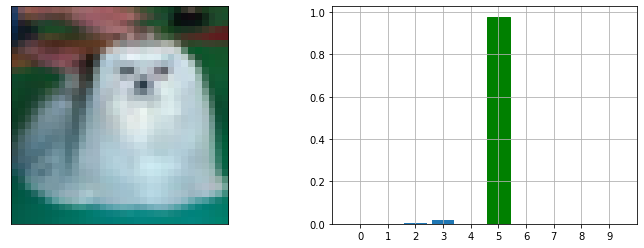

Predicted: собака (5)
True Answer: собака (5)


In [230]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print('True Answer: {} ({})'.format(classes[test_y[idx]],test_y[idx]))

In [231]:
#[0:'самолет', 1:'автомобиль', 2:'птица', 3:'кот', 4:'олень', 5:'собака', 6:'лягушка', 7:'лошадь', 8:'корабль', 9:'грузовик']